In [ ]:
!wget https://os.unil.cloud.switch.ch/fma/fma_small.zip
!unzip fma_small.zip -d fma_small

Se han truncado las últimas 5000 líneas del flujo de salida.
 bunzipping: fma_small/fma_small/068/068601.mp3  
 bunzipping: fma_small/fma_small/068/068680.mp3  
 bunzipping: fma_small/fma_small/068/068682.mp3  
 bunzipping: fma_small/fma_small/068/068683.mp3  
 bunzipping: fma_small/fma_small/068/068820.mp3  
 bunzipping: fma_small/fma_small/068/068821.mp3  
 bunzipping: fma_small/fma_small/068/068837.mp3  
 bunzipping: fma_small/fma_small/068/068838.mp3  
 bunzipping: fma_small/fma_small/068/068839.mp3  
 bunzipping: fma_small/fma_small/068/068840.mp3  
 bunzipping: fma_small/fma_small/068/068841.mp3  
 bunzipping: fma_small/fma_small/068/068842.mp3  
 bunzipping: fma_small/fma_small/068/068843.mp3  
 bunzipping: fma_small/fma_small/068/068844.mp3  
 bunzipping: fma_small/fma_small/068/068851.mp3  
 bunzipping: fma_small/fma_small/068/068852.mp3  
 bunzipping: fma_small/fma_small/068/068853.mp3  
 bunzipping: fma_small/fma_small/068/068854.mp3  
 bunzipping: fma_small/fma_small/068/06

In [ ]:
# Bloque 1: Instalación de dependencias
!pip -q install librosa==0.10.1 soundfile==0.12.1 numpy pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.7/253.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.8 MB/s eta 0:00:00


In [ ]:
# Bloque 2: Importaciones y configuración general
import os, random, math, json, pickle
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

random.seed(42)
np.random.seed(42)

def detect_fma_root():
    candidates = [
        "/content/fma_small",
        "/content/fma_small/fma_small",
        "/content/drive/MyDrive/fma_small",
    ]
    for c in candidates:
        if os.path.isdir(c) and any(d.isdigit() and len(d) == 3 for d in os.listdir(c)):
            return c
    return None

FMA_ROOT = detect_fma_root()
if FMA_ROOT is None:
    raise RuntimeError("No se encontró la carpeta fma_small. Ajusta la ruta en FMA_ROOT.")
else:
    print("Usando FMA_ROOT:", FMA_ROOT)

Usando FMA_ROOT: /content/fma_small/fma_small


In [ ]:
# Bloque 3: Utilidades para listar y seleccionar canciones
def list_audio_files(root, exts=(".mp3", ".wav", ".flac", ".ogg", ".m4a")):
    out = []
    for r, _, files in os.walk(root):
        for f in files:
            if f.lower().endswith(exts):
                out.append(os.path.join(r, f))
    return sorted(out)

def sample_tracks(files, max_tracks=1000):
    if len(files) <= max_tracks:
        return files
    return sorted(random.sample(files, max_tracks))

all_files = list_audio_files(FMA_ROOT)
print("Total de archivos de audio encontrados:", len(all_files))

MAX_TRACKS = 800
audio_files = sample_tracks(all_files, max_tracks=MAX_TRACKS)
print("Archivos seleccionados para el experimento:", len(audio_files))

Total de archivos de audio encontrados: 8000
Archivos seleccionados para el experimento: 800


In [ ]:
# Bloque 4: Extracción y normalización de características
def extract_features(audio_path, sr=22050, n_mfcc=20):
    try:
        y, sr = librosa.load(audio_path, sr=sr, mono=True, duration=30.0)
        if y.size == 0:
            raise ValueError("Audio vacío")
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = mfcc.mean(axis=1)
        mfcc_std = mfcc.std(axis=1)
        rms = librosa.feature.rms(y=y).mean()
        tempo = float(librosa.beat.tempo(y=y, sr=sr, aggregate=np.mean))
        chroma = librosa.feature.chroma_stft(y=y, sr=sr).mean(axis=1)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr).mean(axis=1)
        feat = np.concatenate([mfcc_mean, mfcc_std, [rms, tempo], chroma, contrast])
        return feat.astype(np.float32)
    except Exception:
        return None

def build_feature_store(files):
    store = {}
    for i, p in enumerate(files, start=1):
        f = extract_features(p)
        if f is not None:
            store[p] = f
        if i % 100 == 0:
            print(f"Procesados {i} archivos")
    return store

def normalize_store(store):
    keys = list(store.keys())
    X = np.stack([store[k] for k in keys], axis=0)
    scaler = MinMaxScaler()
    Xn = scaler.fit_transform(X)
    norm = {k: Xn[i] for i, k in enumerate(keys)}
    return norm, scaler

feature_store_raw = build_feature_store(audio_files)
print("Canciones con características válidas:", len(feature_store_raw))

feature_store, scaler = normalize_store(feature_store_raw)
print("Dimensión del vector de características:", next(iter(feature_store.values())).shape[0])

with open("/content/feature_store_fma.pkl", "wb") as f:
    pickle.dump(feature_store, f)
with open("/content/scaler_fma.pkl", "wb") as f:
    pickle.dump(scaler, f)

/tmp/ipython-input-850368340.py:11: FutureWarning: librosa.beat.tempo
	This function was moved to 'librosa.feature.rhythm.tempo' in librosa version 0.10.0.
	This alias will be removed in librosa version 1.0.
  tempo = float(librosa.beat.tempo(y=y, sr=sr, aggregate=np.mean))
/tmp/ipython-input-850368340.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tempo = float(librosa.beat.tempo(y=y, sr=sr, aggregate=np.mean))


Procesados 100 archivos
Procesados 200 archivos
Procesados 300 archivos
Procesados 400 archivos
Procesados 500 archivos
Procesados 600 archivos
Procesados 700 archivos
Procesados 800 archivos
Canciones con características válidas: 800
Dimensión del vector de características: 61


In [ ]:
# Bloque 5: Modelo basado en contenido (similitud coseno)
def topk_similar(song_id, feature_store, k=20):
    keys = [kk for kk in feature_store.keys() if kk != song_id]
    if not keys:
        return []
    q = feature_store[song_id].reshape(1, -1)
    M = np.stack([feature_store[k] for k in keys], axis=0)
    sims = cosine_similarity(q, M).reshape(-1)
    idx = sims.argsort()[::-1]
    k = min(k, len(keys))
    ranked = [(keys[i], float(sims[i])) for i in idx[:k]]
    return ranked

In [ ]:
# Bloque 6: Simulación de usuario y función de recompensa (escenario final)
def simulate_user_profile(feature_store, n_dims=None):
    if n_dims is None:
        n_dims = next(iter(feature_store.values())).shape[0]
    v = np.random.rand(n_dims).astype(np.float32)
    v = v / (np.linalg.norm(v) + 1e-8)
    return v

def similarity_to_profile(vec, profile):
    v = vec / (np.linalg.norm(vec) + 1e-8)
    return float(np.dot(v, profile))

def simulate_event(sim):
    if sim >= 0.92:
        return {"type": "favorite"}
    if sim >= 0.82:
        return {"type": "play"}
    if sim >= 0.70:
        return {"type": "late_skip"}
    return {"type": "early_skip"}

def event_to_reward(event):
    t = event["type"]
    if t == "favorite":
        return 2.0
    if t == "play":
        return 1.0
    if t == "late_skip":
        return -0.5
    return -1.0

In [ ]:
# Bloque 7: Agente de aprendizaje por refuerzo epsilon-greedy (versión final)
class EpsilonGreedyBandit:
    def __init__(self, epsilon_init=0.8, epsilon_min=0.05, decay=0.995):
        self.eps = epsilon_init
        self.eps_min = epsilon_min
        self.decay = decay
        self.values = {}
        self.counts = {}

    def select(self, candidates):
        if len(candidates) == 0:
            return None
        if np.random.rand() < self.eps:
            return random.choice(candidates)[0]
        vals = []
        for c, s in candidates:
            v = self.values.get(c, 0.0)
            vals.append((c, v))
        vals.sort(key=lambda x: x[1], reverse=True)
        return vals[0][0]

    def update(self, song_id, reward):
        n = self.counts.get(song_id, 0) + 1
        v = self.values.get(song_id, 0.0)
        v = v + (reward - v) / n
        self.values[song_id] = v
        self.counts[song_id] = n
        self.eps = max(self.eps * self.decay, self.eps_min)

In [ ]:
# Bloque 8: Métricas de evaluación
def precision_at_k(reco, truth, k):
    k = min(k, len(reco))
    if k == 0:
        return 0.0
    hits = sum(1 for i in reco[:k] if i in truth)
    return hits / k

def recall_at_k(reco, truth, k):
    if len(truth) == 0:
        return 0.0
    hits = sum(1 for i in reco[:k] if i in truth)
    return hits / len(truth)

def dcg_at_k(reco, truth, k):
    dcg = 0.0
    for i, it in enumerate(reco[:k], start=1):
        rel = 1.0 if it in truth else 0.0
        dcg += rel / math.log2(i + 1)
    return dcg

def ndcg_at_k(reco, truth, k):
    dcg = dcg_at_k(reco, truth, k)
    ideal = dcg_at_k(list(truth), truth, min(k, len(truth)))
    if ideal == 0.0:
        return 0.0
    return dcg / ideal

In [ ]:
# Bloque 9: Experimento con conjunto relevante local top-10
def run_experiment(feature_store, episodes=5000, k_pool=30, k_eval=10):
    keys = list(feature_store.keys())
    profile = simulate_user_profile(feature_store)
    agent = EpsilonGreedyBandit(epsilon_init=0.8, epsilon_min=0.05, decay=0.995)
    history = []
    logs = []

    for ep in range(episodes):
        if len(history) == 0:
            seed = random.choice(keys)
        else:
            seed = history[-1]

        pool = topk_similar(seed, feature_store, k=k_pool)
        if not pool:
            break

        candidates = [c for c, _ in pool]
        sims_pool = [similarity_to_profile(feature_store[c], profile) for c in candidates]
        idx_sorted = np.argsort(sims_pool)[::-1]
        k_local = min(k_eval, len(candidates))
        truth_episode = set(candidates[i] for i in idx_sorted[:k_local])

        choice = agent.select(pool)
        if choice is None:
            break

        sim = similarity_to_profile(feature_store[choice], profile)
        event = simulate_event(sim)
        reward = event_to_reward(event)
        agent.update(choice, reward)
        history.append(choice)

        reco_list = [choice]
        p = precision_at_k(reco_list, truth_episode, 1)
        r = recall_at_k(reco_list, truth_episode, 1)
        n = ndcg_at_k(reco_list, truth_episode, 1)

        logs.append(
            {
                "ep": ep + 1,
                "seed": seed,
                "choice": choice,
                "reward": reward,
                "sim": sim,
                "P@k": p,
                "R@k": r,
                "nDCG@k": n,
                "eps": agent.eps,
            }
        )

        if (ep + 1) % 50 == 0:
            print(f"Episodio {ep+1} de {episodes}")

    return pd.DataFrame(logs), history

logs_df, history = run_experiment(feature_store, episodes=5000, k_pool=30, k_eval=10)
logs_df.tail()

Episodio 50 de 5000
Episodio 100 de 5000
Episodio 150 de 5000
Episodio 200 de 5000
Episodio 250 de 5000
Episodio 300 de 5000
Episodio 350 de 5000
Episodio 400 de 5000
Episodio 450 de 5000
Episodio 500 de 5000
Episodio 550 de 5000
Episodio 600 de 5000
Episodio 650 de 5000
Episodio 700 de 5000
Episodio 750 de 5000
Episodio 800 de 5000
Episodio 850 de 5000
Episodio 900 de 5000
Episodio 950 de 5000
Episodio 1000 de 5000
Episodio 1050 de 5000
Episodio 1100 de 5000
Episodio 1150 de 5000
Episodio 1200 de 5000
Episodio 1250 de 5000
Episodio 1300 de 5000
Episodio 1350 de 5000
Episodio 1400 de 5000
Episodio 1450 de 5000
Episodio 1500 de 5000
Episodio 1550 de 5000
Episodio 1600 de 5000
Episodio 1650 de 5000
Episodio 1700 de 5000
Episodio 1750 de 5000
Episodio 1800 de 5000
Episodio 1850 de 5000
Episodio 1900 de 5000
Episodio 1950 de 5000
Episodio 2000 de 5000
Episodio 2050 de 5000
Episodio 2100 de 5000
Episodio 2150 de 5000
Episodio 2200 de 5000
Episodio 2250 de 5000
Episodio 2300 de 5000
Episodio

,ep,seed,choice,reward,sim,P@k,R@k,nDCG@k,eps
4995,4996,/content/fma_small/fma_small/007/007491.mp3,/content/fma_small/fma_small/112/112585.mp3,1.0,0.830866,1.0,0.1,1.0,0.05
4996,4997,/content/fma_small/fma_small/112/112585.mp3,/content/fma_small/fma_small/007/007491.mp3,1.0,0.821807,1.0,0.1,1.0,0.05
4997,4998,/content/fma_small/fma_small/007/007491.mp3,/content/fma_small/fma_small/112/112585.mp3,1.0,0.830866,1.0,0.1,1.0,0.05
4998,4999,/content/fma_small/fma_small/112/112585.mp3,/content/fma_small/fma_small/007/007491.mp3,1.0,0.821807,1.0,0.1,1.0,0.05
4999,5000,/content/fma_small/fma_small/007/007491.mp3,/content/fma_small/fma_small/112/112585.mp3,1.0,0.830866,1.0,0.1,1.0,0.05


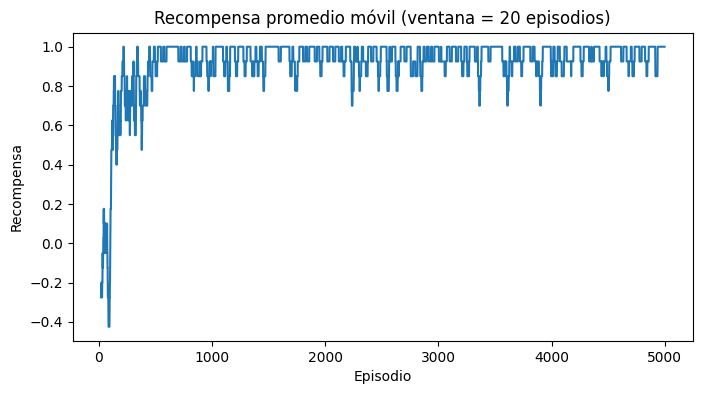

Métricas promedio (ventana final de 50 episodios):
{
  "P@k": 1.0,
  "R@k": 0.1,
  "nDCG@k": 1.0
}


In [ ]:
# Bloque 10: Visualización y ejemplo de recomendaciones
maw = logs_df["reward"].rolling(20).mean()
plt.figure(figsize=(8, 4))
plt.plot(maw)
plt.title("Recompensa promedio móvil (ventana = 20 episodios)")
plt.xlabel("Episodio")
plt.ylabel("Recompensa")
plt.show()

summary = logs_df[["P@k", "R@k", "nDCG@k"]].rolling(50).mean().tail(1).to_dict("records")[0]
print("Métricas promedio (ventana final de 50 episodios):")
print(json.dumps({k: round(v, 4) for k, v in summary.items()}, indent=2))

In [ ]:
# Bloque 11: Agente UCB (Upper Confidence Bound)

class UCBBandit:
    def __init__(self, c=2.0):
        self.c = c
        self.values = {}        # media de recompensas por canción
        self.counts = {}        # número de veces recomendada la canción
        self.total_counts = 0   # total de decisiones del agente

    def select(self, candidates):
        """
        candidates: lista de tuplas (song_id, similarity)
        """
        if len(candidates) == 0:
            return None

        # 1) Buscar canciones no exploradas
        unexplored = [c for c, _ in candidates if self.counts.get(c, 0) == 0]
        if len(unexplored) > 0:
            return random.choice(unexplored)

        # 2) Aplicar la fórmula UCB a las restantes
        best_c = None
        best_ucb = -float("inf")

        self.total_counts = max(self.total_counts, 1)  # evitar log(0)

        for c, _ in candidates:
            n_i = self.counts.get(c, 0)
            v_i = self.values.get(c, 0.0)
            bonus = self.c * math.sqrt(math.log(self.total_counts) / n_i)
            ucb = v_i + bonus
            if ucb > best_ucb:
                best_ucb = ucb
                best_c = c

        return best_c

    def update(self, song_id, reward):
        n = self.counts.get(song_id, 0) + 1
        v = self.values.get(song_id, 0.0)
        v = v + (reward - v) / n  # promedio incremental
        self.values[song_id] = v
        self.counts[song_id] = n
        self.total_counts += 1

In [ ]:
# Bloque 12: Agente Thompson Sampling

class ThompsonBandit:
    def __init__(self):
        # Parámetros alpha y beta de la Beta por canción
        self.alpha = {}  # éxitos "acumulados"
        self.beta = {}   # fracasos "acumulados"

    def _get_params(self, song_id):
        # Prior no informativo Beta(1,1) si no se ha visto la canción
        a = self.alpha.get(song_id, 1.0)
        b = self.beta.get(song_id, 1.0)
        return a, b

    def select(self, candidates):
        """
        candidates: lista de (song_id, sim)
        """
        if len(candidates) == 0:
            return None

        best_c = None
        best_theta = -float("inf")

        for c, _ in candidates:
            a, b = self._get_params(c)
            theta = np.random.beta(a, b)
            if theta > best_theta:
                best_theta = theta
                best_c = c

        return best_c

    def update(self, song_id, reward):
        """
        Actualiza la distribución Beta usando la recompensa transformada a [0,1].
        """
        # Mapear recompensa de [-1, 2] a [0,1]
        r01 = (reward + 1.0) / 3.0
        r01 = float(np.clip(r01, 0.0, 1.0))

        a, b = self._get_params(song_id)
        # r01 como "parte de éxito", (1 - r01) como "parte de fracaso"
        a += r01
        b += (1.0 - r01)

        self.alpha[song_id] = a
        self.beta[song_id] = b

In [ ]:
# Bloque 13: Experimentos UCB y Thompson (misma lógica que run_experiment)

def run_experiment_ucb(feature_store, episodes=5000, k_pool=30, k_eval=10, c_ucb=2.0):
    keys = list(feature_store.keys())
    profile = simulate_user_profile(feature_store)
    agent = UCBBandit(c=c_ucb)
    history = []
    logs = []

    for ep in range(episodes):
        # Semilla igual que en epsilon-greedy
        if len(history) == 0:
            seed = random.choice(keys)
        else:
            seed = history[-1]

        pool = topk_similar(seed, feature_store, k=k_pool)
        if not pool:
            break

        candidates = [c for c, _ in pool]
        sims_pool = [similarity_to_profile(feature_store[c], profile) for c in candidates]
        idx_sorted = np.argsort(sims_pool)[::-1]
        k_local = min(k_eval, len(candidates))
        truth_episode = set(candidates[i] for i in idx_sorted[:k_local])

        choice = agent.select(pool)
        if choice is None:
            break

        sim = similarity_to_profile(feature_store[choice], profile)
        event = simulate_event(sim)
        reward = event_to_reward(event)
        agent.update(choice, reward)
        history.append(choice)

        reco_list = [choice]
        p = precision_at_k(reco_list, truth_episode, 1)
        r = recall_at_k(reco_list, truth_episode, 1)
        n = ndcg_at_k(reco_list, truth_episode, 1)

        logs.append(
            {
                "ep": ep + 1,
                "seed": seed,
                "choice": choice,
                "reward": reward,
                "sim": sim,
                "P@k": p,
                "R@k": r,
                "nDCG@k": n,
                "algo": "UCB",
                "c_ucb": agent.c,
            }
        )

        if (ep + 1) % 50 == 0:
            print(f"[UCB] Episodio {ep+1} de {episodes}")

    return pd.DataFrame(logs), history


def run_experiment_thompson(feature_store, episodes=5000, k_pool=30, k_eval=10):
    keys = list(feature_store.keys())
    profile = simulate_user_profile(feature_store)
    agent = ThompsonBandit()
    history = []
    logs = []

    for ep in range(episodes):
        if len(history) == 0:
            seed = random.choice(keys)
        else:
            seed = history[-1]

        pool = topk_similar(seed, feature_store, k=k_pool)
        if not pool:
            break

        candidates = [c for c, _ in pool]
        sims_pool = [similarity_to_profile(feature_store[c], profile) for c in candidates]
        idx_sorted = np.argsort(sims_pool)[::-1]
        k_local = min(k_eval, len(candidates))
        truth_episode = set(candidates[i] for i in idx_sorted[:k_local])

        choice = agent.select(pool)
        if choice is None:
            break

        sim = similarity_to_profile(feature_store[choice], profile)
        event = simulate_event(sim)
        reward = event_to_reward(event)
        agent.update(choice, reward)
        history.append(choice)

        reco_list = [choice]
        p = precision_at_k(reco_list, truth_episode, 1)
        r = recall_at_k(reco_list, truth_episode, 1)
        n = ndcg_at_k(reco_list, truth_episode, 1)

        logs.append(
            {
                "ep": ep + 1,
                "seed": seed,
                "choice": choice,
                "reward": reward,
                "sim": sim,
                "P@k": p,
                "R@k": r,
                "nDCG@k": n,
                "algo": "Thompson",
            }
        )

        if (ep + 1) % 50 == 0:
            print(f"[Thompson] Episodio {ep+1} de {episodes}")

    return pd.DataFrame(logs), history

In [ ]:
# Bloque 14: Ejecutar los 3 agentes de forma reproducible


def run_all_bandits(seed=42, episodes=5000, k_pool=30, k_eval=10, c_ucb=2.0):
    # Epsilon-Greedy
    reset_seeds(seed)
    logs_eps, hist_eps = run_experiment(
        feature_store, episodes=episodes, k_pool=k_pool, k_eval=k_eval
    )

    # UCB
    reset_seeds(seed)
    logs_ucb, hist_ucb = run_experiment_ucb(
        feature_store, episodes=episodes, k_pool=k_pool, k_eval=k_eval, c_ucb=c_ucb
    )

    # Thompson
    reset_seeds(seed)
    logs_ts, hist_ts = run_experiment_thompson(
        feature_store, episodes=episodes, k_pool=k_pool, k_eval=k_eval
    )

    return logs_eps, logs_ucb, logs_ts

Se han truncado las últimas 5000 líneas del flujo de salida.
[Thompson] Episodio 50050 de 300000
[Thompson] Episodio 50100 de 300000
[Thompson] Episodio 50150 de 300000
[Thompson] Episodio 50200 de 300000
[Thompson] Episodio 50250 de 300000
[Thompson] Episodio 50300 de 300000
[Thompson] Episodio 50350 de 300000
[Thompson] Episodio 50400 de 300000
[Thompson] Episodio 50450 de 300000
[Thompson] Episodio 50500 de 300000
[Thompson] Episodio 50550 de 300000
[Thompson] Episodio 50600 de 300000
[Thompson] Episodio 50650 de 300000
[Thompson] Episodio 50700 de 300000
[Thompson] Episodio 50750 de 300000
[Thompson] Episodio 50800 de 300000
[Thompson] Episodio 50850 de 300000
[Thompson] Episodio 50900 de 300000
[Thompson] Episodio 50950 de 300000
[Thompson] Episodio 51000 de 300000
[Thompson] Episodio 51050 de 300000
[Thompson] Episodio 51100 de 300000
[Thompson] Episodio 51150 de 300000
[Thompson] Episodio 51200 de 300000
[Thompson] Episodio 51250 de 300000
[Thompson] Episodio 51300 de 300000
[Th

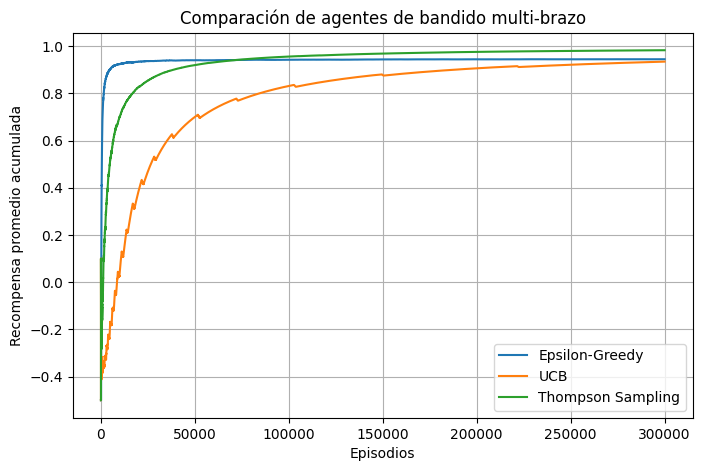

In [ ]:
# Bloque 15: Comparación de Epsilon-Greedy, UCB y Thompson (recompensa promedio acumulada)

def reset_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)

logs_eps, logs_ucb, logs_ts = run_all_bandits(seed=42, episodes=300000, k_pool=30, k_eval=10, c_ucb=2.0)

eps_rewards = logs_eps["reward"].values
ucb_rewards = logs_ucb["reward"].values
ts_rewards  = logs_ts["reward"].values

def running_avg(rewards):
    rewards = np.asarray(rewards, dtype=np.float32)
    if rewards.size == 0:
        return np.array([])
    cumsum = np.cumsum(rewards)
    return cumsum / (np.arange(len(rewards)) + 1)

avg_eps = running_avg(eps_rewards)
avg_ucb = running_avg(ucb_rewards)
avg_ts  = running_avg(ts_rewards)

plt.figure(figsize=(8, 5))
plt.plot(avg_eps, label="Epsilon-Greedy")
plt.plot(avg_ucb, label="UCB")
plt.plot(avg_ts,  label="Thompson Sampling")
plt.xlabel("Episodios")
plt.ylabel("Recompensa promedio acumulada")
plt.title("Comparación de agentes de bandido multi-brazo")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Bloque 16: Métricas finales de los 3 agentes (ventana final = 50 episodios)

def compute_final_metrics(logs_df, window=50):
    """
    Calcula el promedio de P@k, R@k y nDCG@k
    sobre los últimos 'window' episodios.
    """
    if len(logs_df) < window:
        df = logs_df.copy()
    else:
        df = logs_df.tail(window).copy()

    summary = df[["P@k", "R@k", "nDCG@k"]].mean()
    return {
        "P@k": round(summary["P@k"], 4),
        "R@k": round(summary["R@k"], 4),
        "nDCG@k": round(summary["nDCG@k"], 4)
    }

eps_metrics = compute_final_metrics(logs_eps, window=50)
ucb_metrics = compute_final_metrics(logs_ucb, window=50)
ts_metrics  = compute_final_metrics(logs_ts, window=50)

print("=== Comparación de Métricas (ventana final de 50 episodios) ===\n")
print("Epsilon-Greedy:")
print(json.dumps(eps_metrics, indent=2), "\n")

print("UCB:")
print(json.dumps(ucb_metrics, indent=2), "\n")

print("Thompson Sampling:")
print(json.dumps(ts_metrics, indent=2), "\n")

metrics_df = pd.DataFrame({
    "Epsilon-Greedy": eps_metrics,
    "UCB": ucb_metrics,
    "Thompson": ts_metrics
})
metrics_df

=== Comparación de Métricas (ventana final de 50 episodios) ===

Epsilon-Greedy:
{
  "P@k": 0.98,
  "R@k": 0.098,
  "nDCG@k": 0.98
} 

UCB:
{
  "P@k": 1.0,
  "R@k": 0.1,
  "nDCG@k": 1.0
} 

Thompson Sampling:
{
  "P@k": 1.0,
  "R@k": 0.1,
  "nDCG@k": 1.0
} 



,Epsilon-Greedy,UCB,Thompson
P@k,0.980,1.0,1.0
R@k,0.098,0.1,0.1
nDCG@k,0.980,1.0,1.0


In [ ]:
# Bloque 17: Recompensa promedio (últimos 50 episodios)

def reward_last50(logs_df, window=50):
    """
    Calcula la recompensa promedio en los últimos 'window' episodios.
    """
    rewards = logs_df["reward"].tail(window)
    return round(rewards.mean(), 4)

# Calcular recompensas promedio
eps_reward50 = reward_last50(logs_eps)
ucb_reward50 = reward_last50(logs_ucb)
ts_reward50  = reward_last50(logs_ts)

# Crear tabla
reward_table = pd.DataFrame({
    "Agente": ["Epsilon-Greedy", "UCB", "Thompson Sampling"],
    "Recompensa Promedio (Últimos 50 Episodios)": [
        eps_reward50, ucb_reward50, ts_reward50
    ]
})

print("=== Recompensa Promedio en los Últimos 50 Episodios ===")
display(reward_table)

=== Recompensa Promedio en los Últimos 50 Episodios ===


,Agente,Recompensa Promedio (Últimos 50 Episodios)
0,Epsilon-Greedy,0.97
1,UCB,1.00
2,Thompson Sampling,1.00


In [ ]:
# Bloque 18: Tasa de saltos (skip rate) de los 3 agentes

def skip_rate(logs_df):
    """
    Calcula la tasa de saltos basada en la recompensa.
    Skip = reward -1.0 o -0.5
    """
    rewards = logs_df["reward"].values
    total = len(rewards)
    if total == 0:
        return 0.0

    skips = np.sum(rewards < 0)   # saltos = recompensas negativas
    return round(skips / total, 4)

# Calcular la tasa de saltos por agente
eps_skip = skip_rate(logs_eps)
ucb_skip = skip_rate(logs_ucb)
ts_skip  = skip_rate(logs_ts)

skip_table = pd.DataFrame({
    "Agente": ["Epsilon-Greedy", "UCB", "Thompson Sampling"],
    "Tasa de Saltos": [eps_skip, ucb_skip, ts_skip]
})

print("=== Tasa de Saltos por Agente ===")
display(skip_table)

=== Tasa de Saltos por Agente ===


,Agente,Tasa de Saltos
0,Epsilon-Greedy,0.0370
1,UCB,0.0436
2,Thompson Sampling,0.0115
